In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

What is TF-IDF:

TF (Term freq): a measure of how frequently a term occurs in a doc. Given a term t in a given document. The number of times t occurs is divided by the total number of terms in that document.

IDF (Inverse document freq): A "measure" of how important a given term is in a corpus. It's calculated based on log of number of documents divided by the the number of documents that contain t.





TF-IDF = TF * IDF
- The length/size of the vector is == to the size of the learned vocab
(if all your documents contains a total of 50 unique words, the vector is going to have 50D)
- If a term is not present then TDIDF score is zero
'''

In [ ]:
with open('News.CSV', 'r') as file:
  # check what the delimiter is for our CSV file, in this case, columns are separated by a ";"
    for _ in range(5):  # Read the first 5 lines
        line = file.readline()
        print(line)

topic;link;domain;published_date;title;lang

SCIENCE;https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php;eurekalert.org;2020-08-06 13:59:45;A closer look at water-splitting's solar fuel potential;en

SCIENCE;https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw;pulse.ng;2020-08-12 15:14:19;An irresistible scent makes locusts swarm, study finds;en

SCIENCE;https://www.express.co.uk/news/science/1322607/artificial-intelligence-warning-machine-learning-algorithm-social-media-data;express.co.uk;2020-08-13 21:01:00;Artificial intelligence warning: AI will know us better than we know ourselves;en

SCIENCE;https://www.ndtv.com/world-news/glaciers-could-have-sculpted-mars-valleys-study-2273648;ndtv.com;2020-08-03 22:18:26;Glaciers Could Have Sculpted Mars Valleys: Study;en



In [ ]:
# Now we train the TFIDF model on a larger and real life dataset.

news_df = pd.read_csv("News.CSV",sep=";", encoding="utf-8")
news_df.head()

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en


In [ ]:
news_df.shape

(108774, 6)

In [ ]:
news_df = news_df.head(15000) # take the first 15000 entries.

In [ ]:
news_df.shape

(15000, 6)

In [ ]:
try:
  news_df = news_df.title
  news_df.head()
except:
  news_df.head()


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import string
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def normalize(text): #text = text in only one document
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations (universal way)

  tokens = word_tokenize(text) # breaks text up into ["a", "b", "c", etc... ] format if the text is "a b c etc..."
  filter_tokens = [word for word in tokens
                   if word not in stopwords.words("english")
                   and word.isalpha() # no digits
                   and len(word) > 3]

  lemmatizer = WordNetLemmatizer() # create the lemmatizer object to so I can call this method later.
  normalize = [lemmatizer.lemmatize(word) for word in filter_tokens]
  return " ".join(normalize)



In [ ]:
from collections import Counter

def genTfidf(texts, wordcountthreshold = 3):
  #texts = list of all documents where each item is the text of document.
  #wordcountthreshold = how many times a word appears across all documents. Not frequency of the word within a document.
  normalize_docs = [normalize(doc) for doc in texts]
  all_words = [word for doc in normalize_docs for word in word_tokenize(doc)] # get a list of all words in each tokenized document

  counts = Counter(all_words)

  filtered_docs = [] # this is the same as all_words except we take into account wordcountthreshold=3.
  for doc in normalize_docs:
    tokens = word_tokenize(doc)
    filter_tokens = [word for word in tokens
                     if counts[word] > wordcountthreshold]
    filtered_docs.append(" ".join(filter_tokens))

  vectorizer = TfidfVectorizer() # create an instance of TfidVectorizer matrix. Every row is a document index and every column is a term in the corpus.
  matrix = vectorizer.fit_transform(filtered_docs)

  df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
  # vectorizer.get_feature_names_out() returns a list of strings where each string is a unique word in vectorizer, and vectorizer is a TfIdfVectorizer matrix
  # of filtered_docs. Now filtered_docs are words in all documents that are either longer than 3 letters (len(word)>3) or appear more than three times in
  # three different documents
  return df


In [ ]:
documents = news_df.tolist()

In [ ]:
tfidf_df = genTfidf(documents)

In [ ]:
tfidf_df.shape # 15000 is the number of documents, 4353 is the number of unique words that satisfy the conditions of genTfidf.

(15000, 4353)

In [ ]:
similarity = cosine_similarity(tfidf_df)

In [ ]:
np_matrix = tfidf_df.to_numpy()
similarity = cosine_similarity(tfidf_df)
np.fill_diagonal(similarity, np.nan) # ignoring self-similarity, replacing all pivots with "nan" (not a number)

most_doc1_index, most_doc2_index = np.unravel_index(np.nanargmax(similarity), similarity.shape)
least_doc1_index, least_doc2_index = np.unravel_index(np.nanargmin(similarity), similarity.shape)


We pass similarity.shape into np.unravel_index because that method needs to know the array shape in order to translate the 1D index back into the appropriate 2D row,col indexes.

For example, say np.nanargmax returned index 5:

np.unravel_index needs to know number of rows and columns to turn 5 back into (row=1, col=2).

Without passing the shape in, it wouldn't know if 5 maps to a (10x10), (100x5) or some other shape array.

So in summary, we pass in similarity.shape so unravel_index can properly translate the 1D index from nanargmax into the right 2D row,col indexes within the similarity matrix.

In [ ]:
print(documents[most_doc1_index], "\n", documents[most_doc2_index])

Apple TV+ to Launch First Discounted Video Content Bundle 
 Apple TV+ to Launch First Discounted Video Content Bundle


In [ ]:
print(documents[least_doc1_index], "\n", documents[least_doc2_index])

A closer look at water-splitting's solar fuel potential 
 An irresistible scent makes locusts swarm, study finds


# Now let's apply K-Means Algorithm to the dataset

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init="k-means++", max_iter = 500, random_state=2)
  kmeans.fit(tfidf_df)
  wcss.append(kmeans.inertia_)


print(wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[14900.762830657248, 14812.308104232157, 14760.424786303494, 14721.135141196562, 14675.894942584553, 14638.96339978531, 14593.486365224835, 14581.408010934112, 14564.818458343569, 14531.879420695223]


###for kmeans.inertia_, inertia measures the sum of the distances between each data point and its nearest cluster center. Lower inertia indicates the clusters are compact and highly separated. Higher inertia indicates the clusters are more diffuse/overlapping.

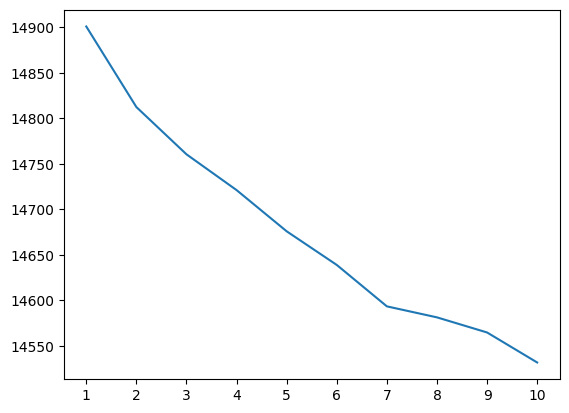

In [ ]:
plt.plot(range(1, 11), wcss)
plt.xticks(range(1,11))
plt.show() # y axis = WCSS | x axis = k (# of clusters)

In [ ]:
# clear elbow at around 7, 8. We'll try n_clusters = 8
kmeans = KMeans(n_clusters = 8, init="k-means++", max_iter = 500, random_state=2)
predictions = kmeans.fit_predict(tfidf_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
tfidf_df["label"] = predictions

In [ ]:
predictions # the number corresponds to which cluster that value belongs to.

array([1, 1, 1, ..., 2, 5, 1], dtype=int32)

In [ ]:
tfidf_df.label.value_counts() # we can see that cluster 0 has the most values.

1    11336
2     1139
6      802
0      500
7      346
3      335
5      333
4      209
Name: label, dtype: int64

In [ ]:
tfidf_df.columns

Index(['abandoned', 'aberdeen', 'ability', 'able', 'aboard', 'abort', 'abroad',
       'absolute', 'abuse', 'academic',
       ...
       'zelda', 'zephyrus', 'zero', 'zeroday', 'zimbabwe', 'zimbabwean',
       'zombie', 'zone', 'zoom', 'zydus'],
      dtype='object', length=4353)

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

centroids = kmeans.cluster_centers_


closest_points = []
for i in range(8):
    distances = np.linalg.norm(tfidf_df[kmeans.labels_ == i] - centroids[i], axis=1)
    closest_point_index = np.argmin(distances)
    closest_point = tfidf_df[kmeans.labels_ == i].iloc[closest_point_index]
    closest_points.append(closest_point)


print(closest_points)

[abandoned     0.0
aberdeen      0.0
ability       0.0
able          0.0
aboard        0.0
             ... 
zimbabwean    0.0
zombie        0.0
zone          0.0
zoom          0.0
zydus         0.0
Name: 3289, Length: 4353, dtype: float64, abandoned     0.0
aberdeen      0.0
ability       0.0
able          0.0
aboard        0.0
             ... 
zimbabwean    0.0
zombie        0.0
zone          0.0
zoom          0.0
zydus         0.0
Name: 163, Length: 4353, dtype: float64, abandoned     0.0
aberdeen      0.0
ability       0.0
able          0.0
aboard        0.0
             ... 
zimbabwean    0.0
zombie        0.0
zone          0.0
zoom          0.0
zydus         0.0
Name: 12968, Length: 4353, dtype: float64, abandoned     0.0
aberdeen      0.0
ability       0.0
able          0.0
aboard        0.0
             ... 
zimbabwean    0.0
zombie        0.0
zone          0.0
zoom          0.0
zydus         0.0
Name: 8577, Length: 4353, dtype: float64, abandoned     0.0
aberdeen      0.0
abi

In [ ]:
print(document[3289], document[163], document[12968], document[8577], document[5734], document[12738], document[7481], document[473])

NameError: ignored